# Titanic Survival Prediction — Project 2 (Modeling)

**Goal:** Build predictive models (Logistic Regression & Random Forest) to estimate survival on the Titanic.

**Data:** Kaggle Titanic `train.csv`. Uses cleaned data from Project 1 if available.  
**Features:** `Pclass`, `Sex`, `Age`, `Fare`, `Embarked`, `FamilySize`, `IsAlone` (+ `AgeBin` if present).

**Pipeline Highlights**
- Train/Test split with `stratify`
- `ColumnTransformer` + `Pipeline`
- Proper encoding & imputation
- Logistic Regression (baseline) & Random Forest (tree model)
- Evaluation: Accuracy, Precision, Recall, F1, ROC-AUC
- Plots: Confusion Matrix (per model), ROC Curve (both models)
- Saves: `models/titanic_model.joblib` & figures in `reports/figures/`

*Author:* _Your Name_  
*Date:* {{replace_with_today}}


In [1]:
# Core
import os
from pathlib import Path
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix, RocCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Save model
import joblib

# Paths
ROOT = Path("..").resolve()  # notebook is in notebooks/
DATA_DIR = ROOT / "data"
REPORTS_DIR = ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
MODELS_DIR = ROOT / "models"

for d in [FIG_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"Root: {ROOT}")
print(f"Figures -> {FIG_DIR}")
print(f"Models -> {MODELS_DIR}")


Root: D:\Road to Ace\titanic-eda
Figures -> D:\Road to Ace\titanic-eda\reports\figures
Models -> D:\Road to Ace\titanic-eda\models


In [2]:
# Prefer cleaned data from Project 1 if present
clean_path = DATA_DIR / "train_cleaned.csv"
raw_path = DATA_DIR / "train.csv"

if clean_path.exists():
    df = pd.read_csv(clean_path)
    print("Loaded:", clean_path)
else:
    print("Loaded raw:", raw_path)
    df = pd.read_csv(raw_path)

    # Minimal clean-up to match Project 1 logic
    # Drop Cabin (too many missing for modeling), basic imputations
    if "Cabin" in df.columns:
        df = df.drop(columns=["Cabin"])
    # Embarked
    if "Embarked" in df.columns:
        df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
    # Fare
    if "Fare" in df.columns:
        df["Fare"] = df["Fare"].fillna(df["Fare"].median())
    # Age impute by (Sex, Pclass) median if possible; else overall median
    if {"Age", "Sex", "Pclass"}.issubset(df.columns):
        df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].transform(lambda s: s.fillna(s.median()))
        df["Age"] = df["Age"].fillna(df["Age"].median())
    elif "Age" in df.columns:
        df["Age"] = df["Age"].fillna(df["Age"].median())

    # Feature engineering to match Project 1
    if {"SibSp", "Parch"}.issubset(df.columns):
        df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
        df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

print(df.shape)
df.head()


Loaded: D:\Road to Ace\titanic-eda\data\train_cleaned.csv
(891, 14)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone,AgeBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,0,YoungAdult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,1,YoungAdult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,0,YoungAdult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,1,YoungAdult


In [3]:
target_col = "Survived"
assert target_col in df.columns, "The dataset must contain 'Survived' for supervised training."

# Candidate features (we'll use whichever exist)
candidate_num = ["Pclass", "Age", "Fare", "FamilySize", "IsAlone"]
candidate_cat = ["Sex", "Embarked"]

# If AgeBin exists (from Project 1), include as categorical
if "AgeBin" in df.columns:
    candidate_cat.append("AgeBin")

# Keep only existing columns
num_features = [c for c in candidate_num if c in df.columns]
cat_features = [c for c in candidate_cat if c in df.columns]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

X = df[num_features + cat_features].copy()
y = df[target_col].astype(int).copy()

# Cast categoricals (important for OneHotEncoder)
for c in cat_features:
    X[c] = X[c].astype("category")

X.head()


Numeric features: ['Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone']
Categorical features: ['Sex', 'Embarked', 'AgeBin']


,Pclass,Age,Fare,FamilySize,IsAlone,Sex,Embarked,AgeBin
0,3,22.0,7.2500,2,0,male,S,YoungAdult
1,1,38.0,71.2833,2,0,female,C,Adult
2,3,26.0,7.9250,1,1,female,S,YoungAdult
3,1,35.0,53.1000,2,0,female,S,YoungAdult
4,3,35.0,8.0500,1,1,male,S,YoungAdult


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


(712, 8) (179, 8)


(Survived
 0    0.616573
 1    0.383427
 Name: proportion, dtype: float64,
 Survived
 0    0.614525
 1    0.385475
 Name: proportion, dtype: float64)

In [5]:
from sklearn.pipeline import Pipeline

# Preprocessor for Logistic Regression (scale numeric)
preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ],
    remainder="drop"
)

# Preprocessor for Random Forest (no scaling needed)
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ],
    remainder="drop"
)

# Pipelines
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor_lr),
    ("model", LogisticRegression(max_iter=500, solver="liblinear", class_weight=None, random_state=RANDOM_STATE))
])

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("model", RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

pipe_lr, pipe_rf


(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['Pclass', 'Age', 'Fare',
                                                    'FamilySize', 'IsAlone']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('onehot',
                                                                    OneHotEncode

In [6]:
def evaluate(model, X_tr, y_tr, X_te, y_te, model_name="model", save_prefix=None):
    y_pred = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        # Some models may not have predict_proba; fall back on decision_function if available
        y_proba = getattr(model, "decision_function", lambda X: None)(X_te)
    
    metrics = {
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_te, y_proba) if y_proba is not None else np.nan
    }
    print(f"\n=== {model_name} ===")
    print(pd.Series(metrics).round(4))
    print("\nClassification Report:")
    print(classification_report(y_te, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    if save_prefix:
        out = FIG_DIR / f"{save_prefix}.png"
        plt.savefig(out, dpi=150)
        print(f"Saved: {out}")
    plt.show()

    return metrics, y_pred, y_proba


def plot_roc_both(models_with_labels, X_test, y_test, save_name="14_roc_both"):
    plt.figure(figsize=(6, 5))
    for model, label in models_with_labels:
        try:
            RocCurveDisplay.from_estimator(model, X_test, y_test, name=label)
        except Exception as e:
            print(f"ROC for {label} skipped: {e}")
    plt.plot([0,1], [0,1], "k--", alpha=0.6)
    plt.title("ROC Curves")
    plt.tight_layout()
    out = FIG_DIR / f"{save_name}.png"
    plt.savefig(out, dpi=150)
    print(f"Saved: {out}")
    plt.show()



=== Logistic Regression ===
accuracy     0.8101
precision    0.7778
recall       0.7101
f1           0.7424
roc_auc      0.8598
dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0     0.8276    0.8727    0.8496       110
           1     0.7778    0.7101    0.7424        69

    accuracy                         0.8101       179
   macro avg     0.8027    0.7914    0.7960       179
weighted avg     0.8084    0.8101    0.8083       179

Saved: D:\Road to Ace\titanic-eda\reports\figures\12_confusion_lr.png


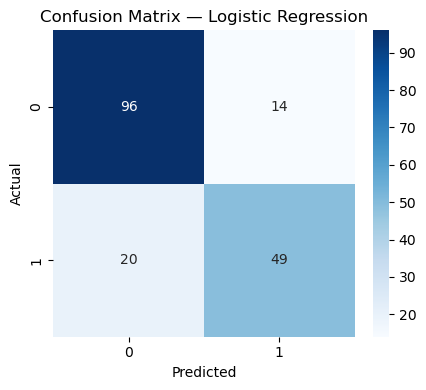


=== Random Forest ===
accuracy     0.7989
precision    0.7705
recall       0.6812
f1           0.7231
roc_auc      0.8396
dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0     0.8136    0.8727    0.8421       110
           1     0.7705    0.6812    0.7231        69

    accuracy                         0.7989       179
   macro avg     0.7920    0.7769    0.7826       179
weighted avg     0.7970    0.7989    0.7962       179

Saved: D:\Road to Ace\titanic-eda\reports\figures\13_confusion_rf.png


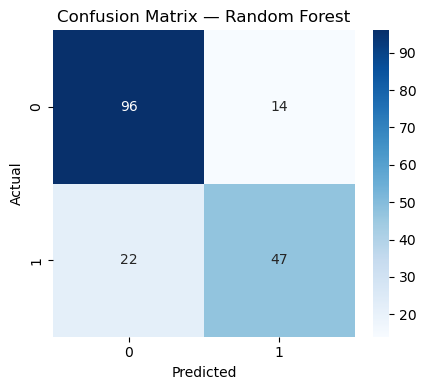

Saved: D:\Road to Ace\titanic-eda\reports\figures\14_roc_both.png


<Figure size 600x500 with 0 Axes>

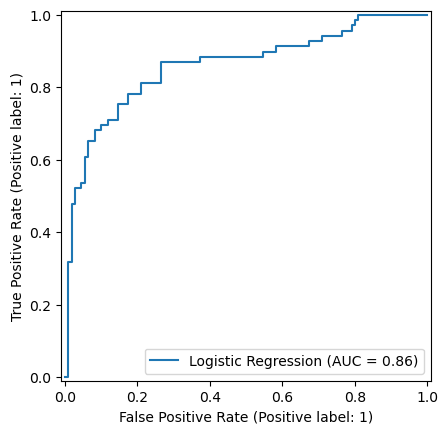

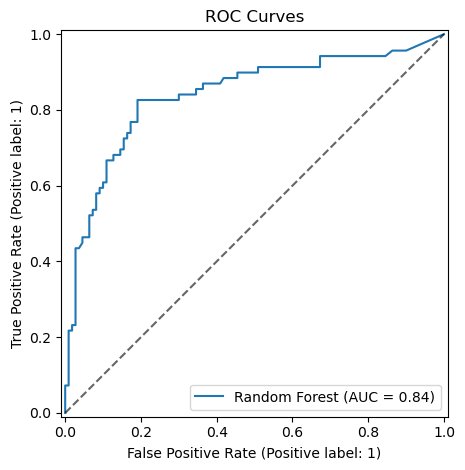

In [7]:
# Fit baseline Logistic Regression
pipe_lr.fit(X_train, y_train)
metrics_lr, ypred_lr, yproba_lr = evaluate(
    pipe_lr, X_train, y_train, X_test, y_test,
    model_name="Logistic Regression", save_prefix="12_confusion_lr"
)

# Fit baseline Random Forest
pipe_rf.fit(X_train, y_train)
metrics_rf, ypred_rf, yproba_rf = evaluate(
    pipe_rf, X_train, y_train, X_test, y_test,
    model_name="Random Forest", save_prefix="13_confusion_rf"
)

# ROC (both)
plot_roc_both([(pipe_lr, "Logistic Regression"), (pipe_rf, "Random Forest")], X_test, y_test)


Best LR params: {'model__C': 10, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Best RF params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}

=== LogReg (Tuned) ===
accuracy     0.7877
precision    0.7013
recall       0.7826
f1           0.7397
roc_auc      0.8622
dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0     0.8529    0.7909    0.8208       110
           1     0.7013    0.7826    0.7397        69

    accuracy                         0.7877       179
   macro avg     0.7771    0.7868    0.7802       179
weighted avg     0.7945    0.7877    0.7895       179



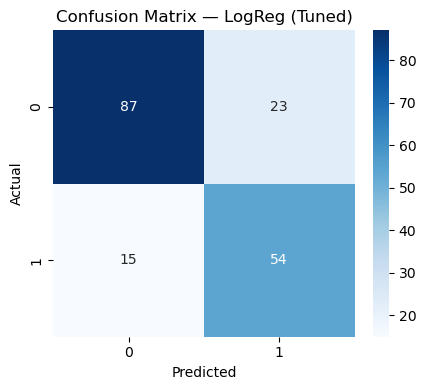


=== RandomForest (Tuned) ===
accuracy     0.7821
precision    0.7419
recall       0.6667
f1           0.7023
roc_auc      0.8378
dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0     0.8034    0.8545    0.8282       110
           1     0.7419    0.6667    0.7023        69

    accuracy                         0.7821       179
   macro avg     0.7727    0.7606    0.7652       179
weighted avg     0.7797    0.7821    0.7797       179



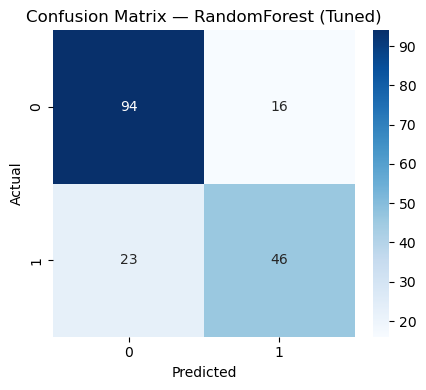

Saved: D:\Road to Ace\titanic-eda\reports\figures\14_roc_both_tuned.png


<Figure size 600x500 with 0 Axes>

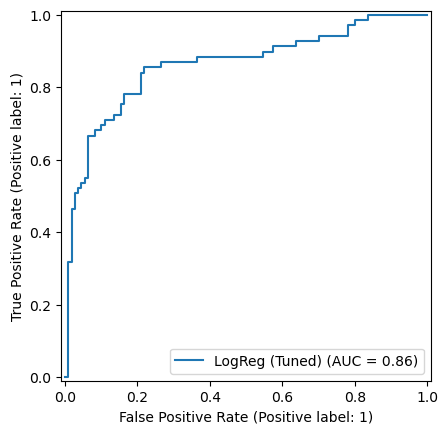

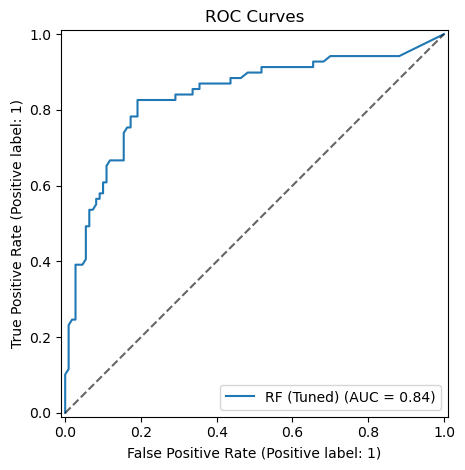

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Logistic Regression grid (L2 only for simplicity)
param_grid_lr = {
    "model__C": [0.1, 1, 10],
    "model__penalty": ["l2"],           # with liblinear we keep l2 here
    "model__class_weight": [None, "balanced"]
}
grid_lr = GridSearchCV(
    estimator=pipe_lr, param_grid=param_grid_lr, cv=cv, scoring="f1", n_jobs=-1, verbose=0
)
grid_lr.fit(X_train, y_train)
print("Best LR params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

# Random Forest grid
param_grid_rf = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", 0.5]
}
grid_rf = GridSearchCV(
    estimator=pipe_rf, param_grid=param_grid_rf, cv=cv, scoring="f1", n_jobs=-1, verbose=0
)
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Evaluate tuned models
metrics_lr_tuned, _, _ = evaluate(best_lr, X_train, y_train, X_test, y_test, "LogReg (Tuned)")
metrics_rf_tuned, _, _ = evaluate(best_rf, X_train, y_train, X_test, y_test, "RandomForest (Tuned)")

# ROC plot (tuned)
plot_roc_both([(best_lr, "LogReg (Tuned)"), (best_rf, "RF (Tuned)")], X_test, y_test, save_name="14_roc_both_tuned")


In [9]:
# Choose the better tuned model by F1 (fallback to ROC-AUC if needed)
def pick_best(m1, m2, m1_name="LR", m2_name="RF"):
    # Using tuned metrics if available, else baseline
    # (This cell assumes you've run the tuning block; otherwise set m1/m2 to baseline pipelines)
    def safe_f1(m, X, y):
        pred = m.predict(X_test)
        return f1_score(y_test, pred)
    f1_1 = safe_f1(m1, X_test, y_test)
    f1_2 = safe_f1(m2, X_test, y_test)
    print(f"{m1_name} F1: {f1_1:.4f} | {m2_name} F1: {f1_2:.4f}")
    return (m1, m1_name) if f1_1 >= f1_2 else (m2, m2_name)

# If you skipped tuning, set best_lr=pipe_lr and best_rf=pipe_rf
best_lr = globals().get("best_lr", pipe_lr)
best_rf = globals().get("best_rf", pipe_rf)

best_model, best_name = pick_best(best_lr, best_rf, "LogReg (best)", "RF (best)")

model_path = MODELS_DIR / "titanic_model.joblib"
joblib.dump(best_model, model_path)
print(f"Saved best ({best_name}) model to: {model_path}")

# Save test predictions
preds_path = REPORTS_DIR / "titanic_test_predictions.csv"
preds_df = X_test.copy()
preds_df["y_true"] = y_test.values
preds_df["y_pred"] = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    preds_df["y_proba"] = best_model.predict_proba(X_test)[:, 1]
preds_df.to_csv(preds_path, index=False)
print(f"Saved predictions -> {preds_path}")
preds_df.head()


LogReg (best) F1: 0.7397 | RF (best) F1: 0.7023
Saved best (LogReg (best)) model to: D:\Road to Ace\titanic-eda\models\titanic_model.joblib
Saved predictions -> D:\Road to Ace\titanic-eda\reports\titanic_test_predictions.csv


,Pclass,Age,Fare,FamilySize,IsAlone,Sex,Embarked,AgeBin,y_true,y_pred,y_proba
565,3,24.0,24.1500,3,0,male,S,YoungAdult,0,0,0.113159
160,3,44.0,16.1000,2,0,male,S,Adult,0,0,0.103782
553,3,22.0,7.2250,1,1,male,C,YoungAdult,1,0,0.185877
860,3,41.0,14.1083,3,0,male,S,Adult,0,0,0.071192
241,3,21.5,15.5000,2,0,female,Q,YoungAdult,1,1,0.832602


## Results Summary

- **Best Model:** (e.g., Random Forest)
- **Test Metrics:**  
  - Accuracy: X.XXX  
  - Precision: X.XXX  
  - Recall: X.XXX  
  - F1-score: X.XXX  
  - ROC-AUC: X.XXX  

**Key Plots:**  
- Confusion Matrix (per model): `reports/figures/12_confusion_lr.png`, `reports/figures/13_confusion_rf.png`  
- ROC (both models): `reports/figures/14_roc_both.png` (or `_tuned`)

**Notes:**  
- Women and 1st class passengers had higher survival rates (from EDA).  
- Model benefits strongly from `Sex`, `Pclass`, `Fare`, and `FamilySize`/`IsAlone`.  
- Consider SHAP or permutation importance for interpretability.


In [1]:
!jupyter nbconvert --to html --no-input \
  --output-dir ../reports --output titanic-modeling.html \
  02_titanic_modeling.ipynb


[NbConvertApp] Converting notebook 02_titanic_modeling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 508030 bytes to ..\reports\titanic-modeling.html
